In [45]:
# Imports and Spark session
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import BooleanType
import os

spark = SparkSession.builder.appName("Food Recommendations").getOrCreate()
print("Spark version:", spark.version)

Spark version: 4.0.1


In [ ]:
# Configuration: adjust as needed
input_path = "output/nutritional_profiles"
fallback_file = "output/nutritional_profiles/part-00000-c8bad44e-47d3-4d65-81e1-c1a23350546a-c000.snappy.parquet"
output_dir = "output/Recommendations"

top_k = 10
sort_by = "carb_per_kcal"  # e.g., 'protein_per_kcal' to sort by a single column; empty to use composite score
ascending = False

# Filters
calorie_min = 0
calorie_max = 800
exclude_allergens = ["gluten", "peanut", "tree nut", "soy", "milk", "egg", "fish", "shellfish", "sesame"]
exclude_keywords = ['lentil', 'tomato']  # e.g., ['pork', 'beef']
include_keywords = ['beef']  # e.g., ['lentil', 'tofu', 'quinoa']
must_include = True   # if True and include_keywords set, only keep rows containing those keywords

# Scoring weights (used when sort_by is empty)
weights = {
    'protein_per_kcal': 1.0,
    'fiber_per_kcal': 0.5,
    'carb_per_kcal': -0.2,
    'sugar_per_kcal': -0.5,
    'fat_per_kcal': -0.3,
    'include_keyword_bonus': 0.3
}

# Control writing outputs
write_outputs = True

In [47]:
# Read Parquet
path = input_path if os.path.exists(input_path) else fallback_file
print("Input path:", path)
df = spark.read.parquet(path)
df.printSchema()

Input path: output/nutritional_profiles
root
 |-- fdc_id: long (nullable = true)
 |-- food_description: string (nullable = true)
 |-- food_type: string (nullable = true)
 |-- total_nutrients: long (nullable = true)
 |-- energy: double (nullable = true)
 |-- protein: double (nullable = true)
 |-- carbs: double (nullable = true)
 |-- total_fat: double (nullable = true)
 |-- water: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- caffeine: double (nullable = true)
 |-- fiber: double (nullable = true)
 |-- sugars: double (nullable = true)
 |-- glucose: double (nullable = true)
 |-- fructose: double (nullable = true)
 |-- sucrose: double (nullable = true)
 |-- lactose: double (nullable = true)
 |-- saturated_fat: double (nullable = true)
 |-- monounsaturated_fat: double (nullable = true)
 |-- polyunsaturated_fat: double (nullable = true)
 |-- trans_fat: double (nullable = true)
 |-- cholesterol: double (nullable = true)
 |-- vitamin_a: 

In [48]:
# Column detection helpers
def detect_column(df, candidates):
    # Exact match first
    for cand in candidates:
        for i, col in enumerate(df.columns):
            if col.lower() == cand.lower():
                return df.columns[i]
    # Contains match fallback
    for cand in candidates:
        for i, col in enumerate(df.columns):
            if cand.lower() in col.lower():
                return df.columns[i]
    return None

id_col = detect_column(df, ['fdc_id', 'id'])
name_col = detect_column(df, ['description', 'food_name', 'name', 'brand_name'])
kcal_col = detect_column(df, ['energy_kcal', 'energy', 'kcal', 'calories', '1008'])
protein_col = detect_column(df, ['protein_g', 'protein', '1003'])
fiber_col = detect_column(df, ['fiber_g', 'fiber', 'dietary_fiber', '1079'])
carb_col = detect_column(df, ['carbohydrate_g', 'carbohydrates', 'carb', 'carbohydrate', '1005'])
sugar_col = detect_column(df, ['sugar_g', 'sugars', 'sugar', '2000'])
fat_col = detect_column(df, ['fat_g', 'fat', 'total_lipid', '1004'])
text_col = detect_column(df, ['ingredients', 'ingredients_text', 'description', 'food_name', 'name', 'brand_name'])

print('Selected columns:')
print(' id:', id_col)
print(' name:', name_col)
print(' kcal:', kcal_col)
print(' protein:', protein_col)
print(' fiber:', fiber_col)
print(' carbs:', carb_col)
print(' sugars:', sugar_col)
print(' fat:', fat_col)
print(' text:', text_col)

if not id_col or not name_col or not kcal_col or not protein_col:
    raise RuntimeError(f"Missing required columns. Available: {df.columns}")

Selected columns:
 id: fdc_id
 name: food_description
 kcal: energy
 protein: protein
 fiber: fiber
 carbs: carbs
 sugars: sugars
 fat: total_fat
 text: food_description


In [49]:
# Build base DataFrame with filters and nutrient densities
def contains_any_udf(keywords):
    lower_keywords = [k.lower() for k in keywords]
    def _fn(text):
        if text is None:
            return False
        t = text.lower()
        for k in lower_keywords:
            if k in t:
                return True
        return False
    return F.udf(_fn, BooleanType())

df_base = df.filter(F.col(kcal_col) > 0)

# Text filters
if text_col:
    exclude_udf = contains_any_udf(exclude_allergens + exclude_keywords)
    include_udf = contains_any_udf(include_keywords)
    df_base = (df_base
        .withColumn('has_excluded', exclude_udf(F.col(text_col)))
        .withColumn('has_included', include_udf(F.col(text_col)))
        .filter(~F.col('has_excluded'))
    )
    if must_include and include_keywords:
        df_base = df_base.filter(F.col('has_included'))
else:
    df_base = df_base.withColumn('has_included', F.lit(False))

# Calorie bounds
df_base = df_base.filter((F.col(kcal_col) >= calorie_min) & (F.col(kcal_col) <= calorie_max))

# Densities per kcal
df_base = df_base.withColumn('protein_per_kcal', F.col(protein_col) / F.col(kcal_col))
if fiber_col:
    df_base = df_base.withColumn('fiber_per_kcal', F.col(fiber_col) / F.col(kcal_col))
if carb_col:
    df_base = df_base.withColumn('carb_per_kcal', F.col(carb_col) / F.col(kcal_col))
if sugar_col:
    df_base = df_base.withColumn('sugar_per_kcal', F.col(sugar_col) / F.col(kcal_col))
if fat_col:
    df_base = df_base.withColumn('fat_per_kcal', F.col(fat_col) / F.col(kcal_col))

print('Rows after filters:', df_base.count())

Rows after filters: 83


In [50]:
# Scoring / Sorting and Top-K output
select_cols = [id_col, name_col, protein_col, kcal_col, 'protein_per_kcal']
for c in ['fiber_per_kcal', 'carb_per_kcal', 'sugar_per_kcal', 'fat_per_kcal', 'has_included']:
    if c in df_base.columns:
        select_cols.append(c)

if sort_by:
    if sort_by not in df_base.columns:
        raise RuntimeError(f"Requested sort-by column '{sort_by}' not found in columns: {df_base.columns}")
    ordered = df_base.orderBy(F.col(sort_by).asc() if ascending else F.col(sort_by).desc())
    recommendations = ordered.select(*select_cols).limit(top_k)
else:
    score = (F.lit(0.0) + F.lit(weights.get('protein_per_kcal', 0.0)) * F.col('protein_per_kcal'))
    if 'fiber_per_kcal' in df_base.columns:
        score = score + F.lit(weights.get('fiber_per_kcal', 0.0)) * F.col('fiber_per_kcal')
    if 'carb_per_kcal' in df_base.columns:
        score = score + F.lit(weights.get('carb_per_kcal', 0.0)) * F.col('carb_per_kcal')
    if 'sugar_per_kcal' in df_base.columns:
        score = score + F.lit(weights.get('sugar_per_kcal', 0.0)) * F.col('sugar_per_kcal')
    if 'fat_per_kcal' in df_base.columns:
        score = score + F.lit(weights.get('fat_per_kcal', 0.0)) * F.col('fat_per_kcal')
    score = score + F.lit(weights.get('include_keyword_bonus', 0.0)) * F.when(F.col('has_included'), F.lit(1.0)).otherwise(F.lit(0.0))
    recommendations = (df_base
        .withColumn('score', score)
        .select(*select_cols, 'score')
        .orderBy(F.col('score').asc() if ascending else F.col('score').desc())
        .limit(top_k)
    )

recommendations.show(truncate=False)

# Optional write outputs
if write_outputs:
    os.makedirs(output_dir, exist_ok=True)
    (recommendations
        .coalesce(1)
        .write
        .mode('overwrite')
        .option('header', True)
        .csv(os.path.join(output_dir, 'top_csv'))
    )
    (recommendations
        .coalesce(1)
        .write
        .mode('overwrite')
        .parquet(os.path.join(output_dir, 'top_parquet'))
    )
    print('Saved:', output_dir)

+-------+------------------------------------------------+-------+------+-------------------+--------------+-------------------+-------------------+--------------------+------------+
|fdc_id |food_description                                |protein|energy|protein_per_kcal   |fiber_per_kcal|carb_per_kcal      |sugar_per_kcal     |fat_per_kcal        |has_included|
+-------+------------------------------------------------+-------+------+-------------------+--------------+-------------------+-------------------+--------------------+------------+
|2510037|PEPPERED MEGA SLAB CLASSIC BEEF JERKY, MEGA SLAB|35.71  |357.0 |0.10002801120448179|0.0           |0.1400560224089636 |0.13005602240896358|0.01                |true        |
|476781 |ORIGINAL BEEF JERKY                             |25.0   |179.0 |0.13966480446927373|0.0           |0.09977653631284916|0.09977653631284916|0.0                 |true        |
|888414 |PEPPERED BEEF JERKY, PEPPERED                   |32.14  |286.0 |0.1123776223

## Usage
1. Rulează celulele 1–4 pentru inițializare și citirea datelor.
2. În Celula 3, modifică preferințele: `exclude_allergens`, `include_keywords`, `exclude_keywords`, `calorie_min/max`, `sort_by` sau `weights`.
3. Rulează celulele 5–7 pentru detectare coloane, filtrare, scor/sort și Top-K.
4. Rezultatele se pot scrie în `output/Recommendations` dacă `write_outputs = True`.

/tmp/ipykernel_8454/482342825.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pdf_display[c] = pd.to_numeric(pdf_display[c], errors='ignore')


ID,Food,Protein (g),Calories (kcal),Protein/kcal,Fiber/kcal,Carb/kcal,Sugar/kcal,Fat/kcal,Included?
2510037,"PEPPERED MEGA SLAB CLASSIC BEEF JERKY, MEGA SLAB",35.710,357.000,0.100,0.000,0.140,0.130,0.010,✅
476781,ORIGINAL BEEF JERKY,25.000,179.000,0.140,0.000,0.100,0.100,0.000,✅
888414,"PEPPERED BEEF JERKY, PEPPERED",32.140,286.000,0.112,nan,0.100,0.087,0.012,✅
1289948,BEEF JERKY,35.710,286.000,0.125,0.000,0.100,0.087,0.006,✅
1846463,"PEPPERED BEEF JERKY PREMIUM CUT STRIPS, PEPPERED",21.430,286.000,0.075,0.000,0.100,0.087,0.012,✅
1109427,SMOKEY TERIYAKI BEEF JERKY,35.710,321.000,0.111,0.000,0.078,0.078,0.028,✅
1668490,CRACKED BLACK PEPPER FLAVORED BEEF JERKY,32.140,286.000,0.112,0.000,0.075,0.075,0.012,✅
2101160,TERIYAKI BEEF JERKY,39.290,286.000,0.137,0.000,0.087,0.075,0.012,✅
1302983,"BEEF JERKY, TERIYAKI",41.180,294.000,0.140,0.000,0.080,0.073,0.013,✅
1652626,"TERIYAKI BEEF JERKY, TERIYAKI",46.430,286.000,0.162,0.000,0.062,0.062,0.012,✅


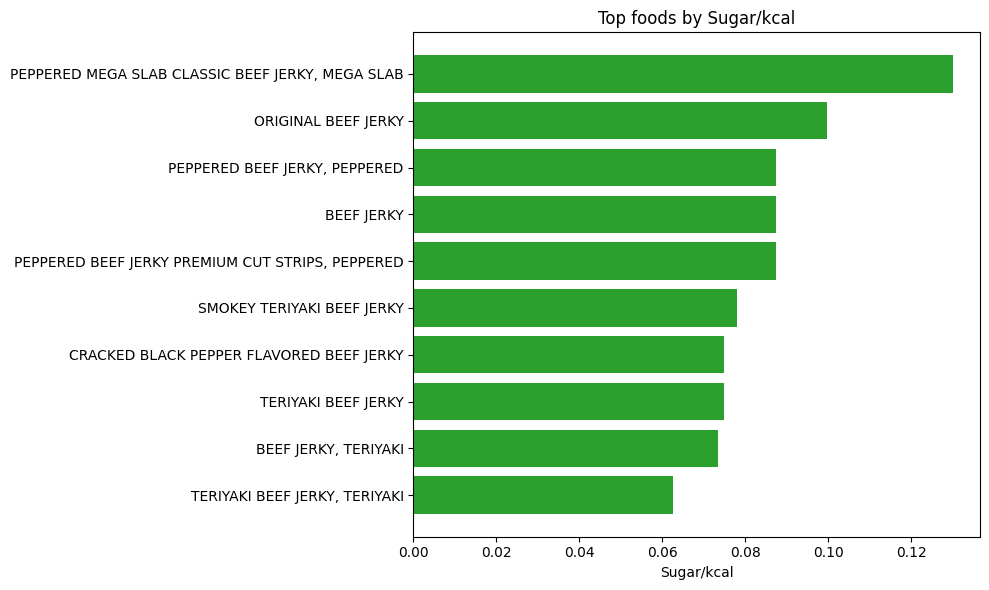

In [51]:
# Pretty display of Top-K recommendations within the notebook
import pandas as pd
from IPython.display import display

# Convert Spark DataFrame to Pandas
pdf = recommendations.toPandas()

# Friendly column names
col_map = {
    id_col: 'ID',
    name_col: 'Food',
    protein_col: 'Protein (g)',
    kcal_col: 'Calories (kcal)',
    'protein_per_kcal': 'Protein/kcal',
    'fiber_per_kcal': 'Fiber/kcal',
    'carb_per_kcal': 'Carb/kcal',
    'sugar_per_kcal': 'Sugar/kcal',
    'fat_per_kcal': 'Fat/kcal',
    'score': 'Score',
    'has_included': 'Included?'
}

pdf = pdf.rename(columns={k: v for k, v in col_map.items() if k in pdf.columns})

# If Included? exists, convert to checkmarks
if 'Included?' in pdf.columns:
    pdf['Included?'] = pdf['Included?'].apply(lambda x: '✅' if bool(x) else '—')

# Choose display columns in a sensible order
ordered_cols = ['ID', 'Food', 'Protein (g)', 'Calories (kcal)', 'Protein/kcal',
                'Fiber/kcal', 'Carb/kcal', 'Sugar/kcal', 'Fat/kcal', 'Score', 'Included?']
display_cols = [c for c in ordered_cols if c in pdf.columns]

# Round numeric columns
num_cols = [c for c in display_cols if c not in ['ID', 'Food', 'Included?']]
pdf_display = pdf[display_cols].copy()
for c in num_cols:
    try:
        pdf_display[c] = pd.to_numeric(pdf_display[c], errors='ignore')
    except Exception:
        pass

# Determine the metric to highlight based on sort_by or score fallback
metric_display = None
try:
    if sort_by and str(sort_by).strip():
        metric_display = col_map.get(sort_by, sort_by)
    else:
        if 'Score' in pdf_display.columns:
            metric_display = 'Score'
        elif 'Protein/kcal' in pdf_display.columns:
            metric_display = 'Protein/kcal'
except Exception:
    pass

styler = (
    pdf_display.style
    .format(precision=3)
    .set_caption(f"Top {len(pdf_display)} foods")
)

# Hide index compatibly across pandas versions
try:
    if hasattr(styler, 'hide_index'):
        styler = styler.hide_index()
    elif hasattr(styler, 'hide'):
        styler = styler.hide(axis='index')
except Exception as e:
    print('Index hide skipped:', e)

# Add gradient for the chosen metric
if metric_display and metric_display in pdf_display.columns:
    styler = styler.background_gradient(cmap='Greens', subset=[metric_display])

display(styler)

# Optional chart: use the same chosen metric
try:
    if 'Food' in pdf_display.columns and metric_display and metric_display in pdf_display.columns:
        import matplotlib.pyplot as plt
        plot_df = pdf_display.sort_values(metric_display, ascending=ascending).head(top_k) if ascending else pdf_display.sort_values(metric_display, ascending=False).head(top_k)
        plt.figure(figsize=(10, 6))
        plt.barh(plot_df['Food'], plot_df[metric_display], color='#2ca02c')
        plt.gca().invert_yaxis()
        plt.xlabel(metric_display)
        plt.title(f'Top foods by {metric_display}')
        plt.tight_layout()
        plt.show()
except Exception as e:
    print('Chart skipped:', e)